# KORG abundance fitting for GALAH spectra

-- M. McKenzie, UNSW 7/8/2024


**Tutorial:**
https://github.com/ajwheeler/Korg.jl/blob/main/misc/Tutorial%20notebooks/basics/Python%20Basics.ipynb

**API:**
https://ajwheeler.github.io/Korg.jl/stable/API/#API

## Imports 

Check the github page for info on the installation process


## Notes

This notebook doesn't go through deriving stellar parameters of GALAH stars. There is an example of calculating stellar parameters in the KORG tutorial notebooks. There are more caviates and subtlties involved with stellar parameters anyway...

In [2]:
from juliacall import Main as jl

jl.seval("using Korg")
Korg = jl.Korg

In [3]:
# Usual python imports

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

from astropy.io import fits

In [4]:
# RC params - no ugly plots allowed
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 18
rcParams["axes.edgecolor"] = 'black'
rcParams["legend.edgecolor"] = '0.8'
plt.rcParams.update({'errorbar.capsize': 2})
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['text.latex.preamble']=r'\usepackage{amsmath}'


pd.options.mode.chained_assignment = None  # default='warn'

# for pandas tables
pd.set_option('display.max_columns', 500)

## Line list and wavelength regions

Select wavelength region we want to fit spectra to and filter the master GALAH line list accordingly

In [5]:
# Wavelength region of what we will be fitting 
wl1_spectra = 6485 # the lower bound of the wavelength in Angstroms in air
wl2_spectra = 6510 # the upper bound of the wavelength in Angstroms in air


# Filtering the size of the line list to the region around your wavelength region to speed up computation.
# Not entirely neccecary, but it can sometimes be helpful.

# include just outside the wavelength range just in case you need to account for a large spectral feature.
wl1_ll = wl1_spectra - 20
wl2_ll = wl2_spectra + 20

lines = jl.collect([l for l in Korg.get_GALAH_DR3_linelist() if (wl1_ll < l.wl*1e8) and (l.wl*1e8 < wl2_ll)])


In [6]:
# Put it into Julia format to send to KORG
synthesis_wls = jl.seval( str(np.round(Korg.air_to_vacuum(wl1_ll+1), 2)) + ':0.01:' + str(np.round(Korg.air_to_vacuum(wl2_ll+1), 2)))  # note, wider wavelength range or fit_spectrum breaks

galah_synthesis_wls = jl.seval('[' + str(np.round(Korg.air_to_vacuum(wl1_spectra), 2)) + ':0.01:' + str(np.round(Korg.air_to_vacuum(wl2_spectra), 2)) + ']') # wavelength range where you're fitting

## GALAH Spectra

### Setting GALAH stellar parameters
See above - we are not calculating stellar parameters here

In [7]:
# Korg synthesis
spectra_teff  = 4240
spectra_logg  = 1.01
spectra_m_H   = -1.81 #([Fe/H])
spectra_vsini = 6.1
spectra_vmic  = 1.77

# Based on GALAH abundances
fixed_params = dict(Teff = spectra_teff, logg =spectra_logg, m_H = spectra_m_H, vsini = spectra_vsini, vmic= spectra_vmic)

# Set the model atmospere for the star
A_X =  Korg.format_A_X(spectra_m_H)
spectra_df_atm = Korg.interpolate_marcs(spectra_teff, spectra_logg, A_X)

### Reading in the GALAH spectra

Update path to spectra accordingly.

In [15]:
# read in the GALAH spectra
# Open the FITS file
# hdul = fits.open('/Users/mckenzie/Library/CloudStorage/OneDrive-AustralianNationalUniversity/GALAH_idr4/Li_rich_giant/m22/230802002101398/230802002101398_allstar_fit_spectrum.fits')

data_dir = "/Users/z5114326/Documents/GitHub/KorgTest/151110003701137/151110003701137_allstar_fit_spectrum.fits"
# data_dir = "/Users/z5114326/Documents/GitHub/KorgTest/230802002101398/230802002101398_allstar_fit_spectrum.fits"
hdul = fits.open(data_dir)

# Assuming the spectral data is in the first extension
spectra_data = hdul[1].data

# Converting wavelength to vacuum
spectra_data_vacuum = []
for wl in spectra_data['wave']:
    spectra_data_vacuum.append(Korg.air_to_vacuum(wl))

spectra_data_vacuum = np.asarray(spectra_data_vacuum)

# Turn into a dataframe
spectra_df = pd.DataFrame({'wl': spectra_data_vacuum, 'wl_air':spectra_data['wave'].astype('float64'), 'flux': spectra_data['sob'].astype('float64'), 'error': spectra_data['uob'].astype('float64')})

In [16]:
# Taking the spectra around the wavelength region specified above
spectra_df_fit_region = spectra_df[(spectra_df['wl_air'] > wl1_spectra) & (spectra_df['wl_air'] < wl2_spectra)]

In [17]:
def plot_spectra(ax, spectra_df_fit_region):
    ax.scatter(spectra_df_fit_region.wl_air, spectra_df_fit_region.flux, marker = '+', color = 'indigo', linewidths=0.5, s = 100, zorder = 10, label = 'Spectra')
    
    # use fill between to plot the errors
    ax.fill_between(spectra_df_fit_region.wl_air, spectra_df_fit_region.flux - spectra_df_fit_region.error, spectra_df_fit_region.flux + spectra_df_fit_region.error, color = 'grey', alpha = 0.9, zorder = -1, label = 'Error')

    # plot a horizontal line at 1
    ax.axhline(y=1, color='darkslategrey', linestyle='--', linewidth = 0.5, zorder = -1)

    # Set minor tick locators
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(direction='in', axis='both', which='both', 
    bottom=True,top=True, left=True, right=True)

    ax.set_ylim(top = 1.04)

    ax.set_xlabel(r'Wavelength ($\AA$)')
    ax.set_ylabel('Flux')

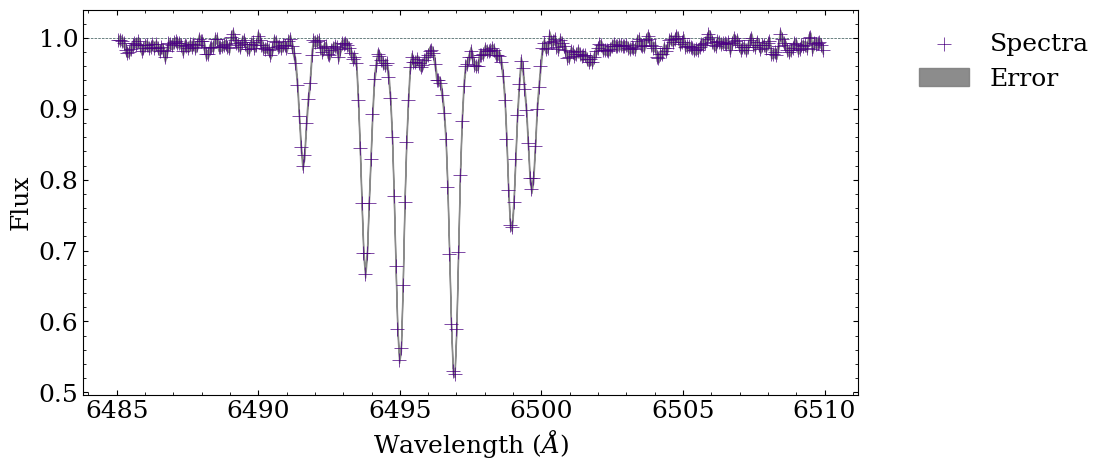

In [18]:
# plot the spectra to make sure its what you expect
fig, ax = plt.subplots(figsize = (10, 5))

plot_spectra(ax, spectra_df_fit_region)

ax.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

### And aside: see what significant lines are in this region

In [19]:
# Play around with threshold to see how picky the algorithm wants to be
notable_lines = Korg.prune_linelist(spectra_df_atm, lines, A_X, Korg.air_to_vacuum(wl1_spectra), Korg.air_to_vacuum(wl2_spectra), threshold = 5)
merged_lines =  Korg.merge_close_lines(notable_lines, merge_distance=0.2)

spectra_merged_lines = pd.DataFrame(merged_lines, columns= ['wl', 'wl_low','wl_high', 'species'])
spectra_merged_lines['wl_air'] = [Korg.vacuum_to_air(wl) for wl in spectra_merged_lines['wl']]

measuring 12 lines 100%|█████████████████████████████████| Time: 0:00:01


### Plot spectra again to see what the strongest lines are

In [20]:
def plot_lines(ax, spectra_merged_lines, spectra_min):
    # plot location of strong lines
    for i in range(len(spectra_merged_lines)):
        plt.vlines(spectra_merged_lines.wl_air, spectra_min - 0.25, 1.05, zorder = -2, color = 'black', linewidth = 0.5, alpha = 0.2)
        # plot text at the location of the line
        plt.text(spectra_merged_lines.wl_air.iloc[i], spectra_min - 0.2, str(spectra_merged_lines.species.iloc[i]), rotation=90, ha='right', va='bottom')

    ax.set_ylim(bottom = spectra_min - 0.22)

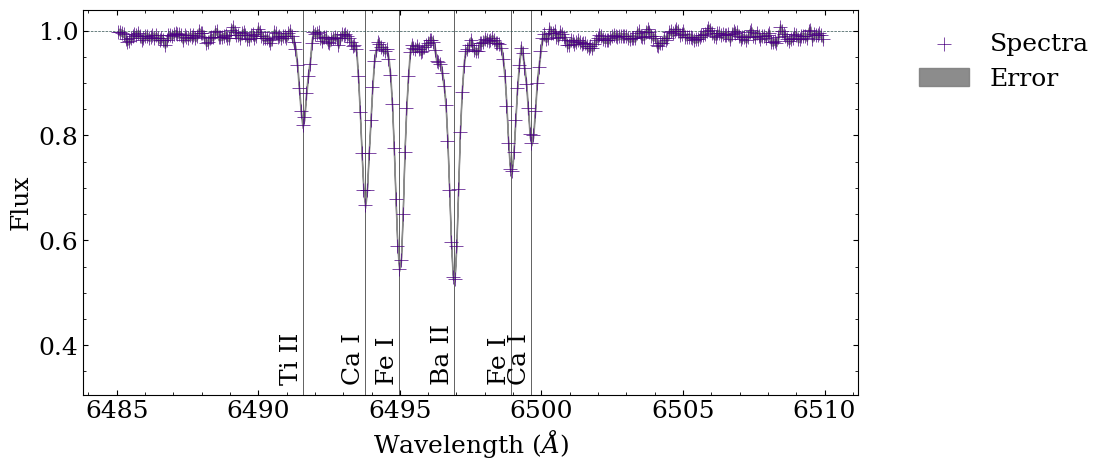

In [21]:
fig, ax = plt.subplots(figsize = (10, 5))

plot_spectra(ax, spectra_df_fit_region)

# plot location of strong lines
plot_lines(ax, spectra_merged_lines, spectra_df_fit_region.flux.min())

# legend with no frame  
ax.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

## Spectrum synthesis

### Set up the line spread function (LSF) for the spectra

Set to the resolution of GALAH at R = 28,000

In [22]:
galah_LSF_matrix = Korg.compute_LSF_matrix(
    galah_synthesis_wls,
    spectra_df_fit_region.wl_air.values,
    28000)

LSF_matrix = Korg.compute_LSF_matrix(
    synthesis_wls,
    spectra_df_fit_region.wl_air.values,
    28000)

### setting up the parameters

In [23]:
# add more parameters and change initial values
params = dict(Ca = -1.8, Ti = -1.8, Fe = -1.9, Ba = -1.8)

### Syntheise the spectra

plot to visualise output

In [24]:
# Synthesise the spectra
synthesis = Korg.synthesize(spectra_df_atm, lines, Korg.format_A_X(spectra_m_H, params), synthesis_wls, vmic = spectra_vmic, air_wavelengths=True)
plt_flux = LSF_matrix * jl.collect(np.array(synthesis.flux) / np.array(synthesis.cntm))

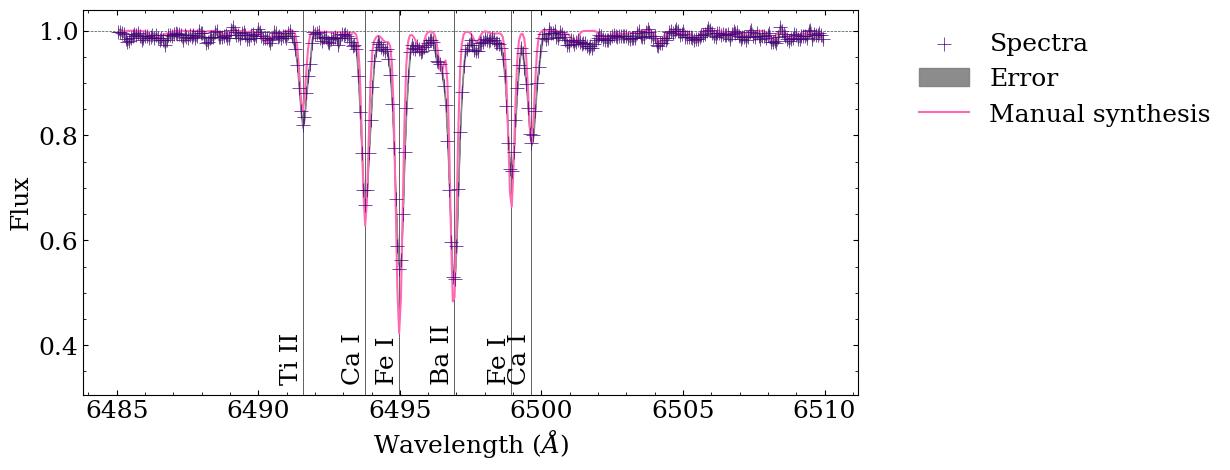

In [25]:
fig, ax = plt.subplots(figsize = (10, 5))

plot_spectra(ax, spectra_df_fit_region)

# plot location of strong lines
plot_lines(ax, spectra_merged_lines, spectra_df_fit_region.flux.min())

# add the synthesis
plt.plot(spectra_df_fit_region.wl_air, plt_flux, label = 'Manual synthesis', color = 'hotpink')


ax.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

## Spectra fitting

In [26]:
# This function might take some time to run..
fit_result = Korg.Fit.fit_spectrum(spectra_df_fit_region.wl_air.values,
    spectra_df_fit_region.flux.values,
    spectra_df_fit_region.error.values,
    lines,
    params,
    fixed_params,
    synthesis_wls = synthesis_wls,
    LSF_matrix = LSF_matrix,
    air_wavelengths=True)

### Make a plot of the fit

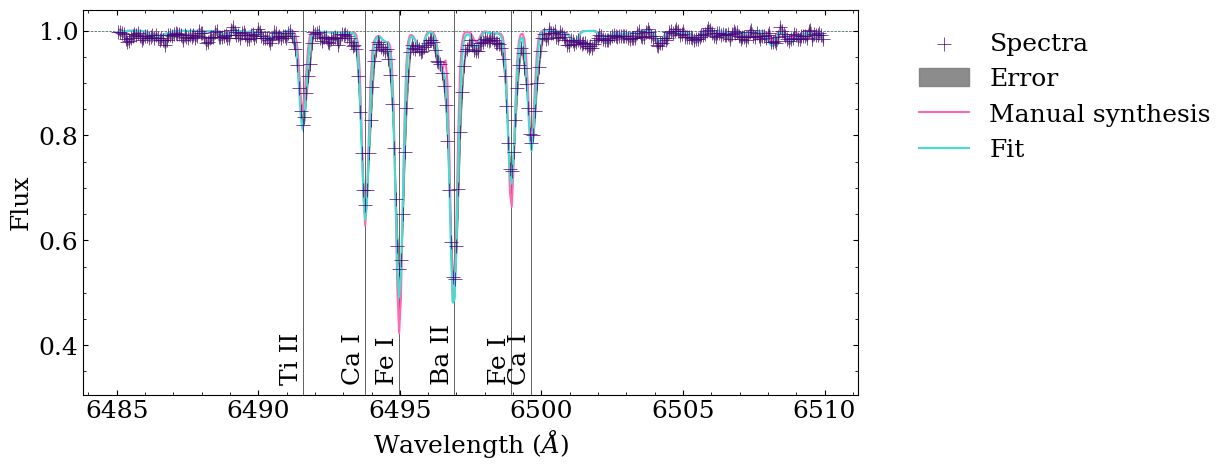

In [27]:
fig, ax = plt.subplots(figsize = (10, 5))

plot_spectra(ax, spectra_df_fit_region)

# plot location of strong lines
plot_lines(ax, spectra_merged_lines, spectra_df_fit_region.flux.min())


# add the synthesis
plt.plot(spectra_df_fit_region.wl_air, plt_flux, label = 'Manual synthesis', color = 'hotpink')

# add the fit
plt.plot(spectra_df_fit_region.wl_air, np.array(fit_result.best_fit_flux), label = 'Fit', color = 'turquoise')

ax.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [28]:
print("output froom BFGS:")
fit_result.best_fit_params

output froom BFGS:


Dict{String, Float64} with 4 entries:
  "Ti" => -1.4812
  "Ca" => -1.57738
  "Fe" => -1.89195
  "Ba" => -1.347